TODO

- Try training with small dataset on laptop.  How long does it take? (100 images per category)
- Get desktop setup for training with GPU
- Crop out borders.  If they are different brands between test cases this will be a problem

# Data Prep

### Random Sampling

`ls ../snapshot/Elephant | sort -R  > random_elephant`

`head -n 100 random_elephant | xargs -I{} cp ../snapshot/Elephant/{} elephant`

`tail -n 100 random_elephant | xargs -I{} ../snapshot/Elephant/{} test/elephant`

### Flatten Tapir Directory
Find every file recursively that ends in .txt, execute the copy command.

`find . -iname '*.JPG' -exec mv \{\} ../tapir_flat/ \;`

### Cleanup images

# Transfer Learning Results
## Simple 100 image retrain
Final test accuracy = 79.5% (N=44) when doing top prediction



In [ ]:
# Default codebase is vagrant
# If you aren't using vagrant replace codebase with your personal
# root.  For example, ~/home/projects/code-base
CODEBASE_DIR = '/vagrant'

# Model Constants
DATA_DIR = CODEBASE_DIR + '/data'
MODELS_DIR = CODEBASE_DIR + '/models'
MODEL_FILE = MODELS_DIR + '/inception-retrained-100imgs/output_graph.pb'
LABELS_FILE = MODELS_DIR + '/inception-retrained-100imgs/output_labels.txt'

# Data Constants
ELEPHANT_DIR = DATA_DIR + '/small-testing/elephant'
RHINO_DIR = DATA_DIR + '/small-testing/rhino'
TAPIR_DIR = DATA_DIR + '/small-testing/tapir'
ANY_DIR = DATA_DIR + '/small-testing/none'

GRAPH_CREATED = False

In [1]:
from IPython.display import Image

from PIL import Image as Img

import numpy as np
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

np.random.seed(1)

In [2]:
def create_graph(file):
    global GRAPH_CREATED
    if GRAPH_CREATED:
        return
    
    GRAPH_CREATED = True
    
    """Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(file, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [3]:
def run_inference_on_image(img):
    answer = None

    if not tf.gfile.Exists(img):
        tf.logging.fatal('File does not exist %s', img)
        return answer

    image_data = tf.gfile.FastGFile(img, 'rb').read()

    # Creates graph from saved GraphDef.
    create_graph(MODEL_FILE)
    
    with tf.Session() as sess:
        softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
        predictions = sess.run(softmax_tensor,
                               {'DecodeJpeg/contents:0': image_data})
        predictions = np.squeeze(predictions)
                
        with open(LABELS_FILE) as f:
            labels = f.read().splitlines()
            
        return (predictions, labels)

In [ ]:
img_elephant = [os.path.join(ELEPHANT_DIR, img) for img in os.listdir(ELEPHANT_DIR)]

img_idx = np.random.randint(0, len(img_elephant), 5)

In [ ]:
Image(img_elephant[img_idx[0]])

In [ ]:
run_inference_on_image(img_elephant[img_idx[0]])

In [4]:
def sample_and_label(img_list, prob, label):
    imgs = np.array(img_list)
    keep = np.random.choice((True,False), size=len(img_list), replace=True, p=prob)
    return label_data(imgs[keep], label)

def label_data(source_data, label):
    sample_size = len(source_data)
    known_labels = np.array([label] * sample_size).reshape(sample_size, 1)
    known_images = source_data.reshape(sample_size,1)
    labeled_data = np.hstack((known_images, known_labels))
    return labeled_data

In [5]:
def stream_classify(pos_dir, pos_sample=(0.01, 0.99)):
    img_pos = [os.path.join(pos_dir, img) for img in os.listdir(pos_dir)]

    # Create a stream of labeled data for rhinos
    labeled_data = sample_and_label(img_pos, prob=pos_sample, label=True)

    i = 0
    rows, col = labeled_data.shape
    score = []
    for labeled in labeled_data:
        i += 1
        img, label = labeled
        sys.stdout.write("\rClassifying %i of %i, img %s                                                         " % (i, rows, img))
        score.append(run_inference_on_image(img))

    sys.stdout.write("\rDONE classifying images                                                                  ")
    return score

In [ ]:
classifications = {}

for pos_dir, label, pos_sample_size in [(TAPIR_DIR, 'tapir', (1.0, 0.0)),
                                        (ANY_DIR, 'none', (1.0, 0.0)),
                                        (RHINO_DIR, 'rhino', (1.0, 0.0)),
                                        (ELEPHANT_DIR, 'elephant', (1.0, 0.0))]:
    classifications[label] = stream_classify(pos_dir=pos_dir, pos_sample=pos_sample_size)

In [6]:
## Binary Data for Elephant
def get_score(label, tup):
    scores, labels = tup
    return scores[labels.index(label)]

def get_label_scores(classif, label):
    label_scores = []

    for item in classif:
        scores, labels = item
        label_scores.append(scores[labels.index(label)])
    
    return label_scores

In [ ]:
elephant_dataset = classifications['elephant']
none_dataset = classifications['none']
rhino_dataset = classifications['rhino']
tapir_dataset = classifications['tapir']


elephant_scores = np.array(get_label_scores(elephant_dataset, 'elephant'))
rhino_scores = np.array(get_label_scores(rhino_dataset, 'rhino'))
tapir_scores = np.array(get_label_scores(tapir_dataset, 'tapir'))

# For our negative examples, we want to compare the probability of NOT label, in the none dataset
none_elephant_scores = np.array(get_label_scores(none_dataset, 'elephant'))
none_rhino_scores = np.array(get_label_scores(none_dataset, 'rhino'))
none_tapir_scores = np.array(get_label_scores(none_dataset, 'tapir'))

In [ ]:
# PR Curve

elephant_truth = np.hstack(([True] * len(elephant_scores), [False] * len(none_elephant_scores)))
elephant_full_scores = np.hstack((elephant_scores, none_elephant_scores))
elephant_precision, elephant_recall, elephant_thresholds = precision_recall_curve(elephant_truth, elephant_full_scores)

rhino_truth = np.hstack(([True] * len(rhino_scores), [False] * len(none_rhino_scores)))
rhino_full_scores = np.hstack((rhino_scores, none_rhino_scores))
rhino_precision, rhino_recall, rhino_thresholds = precision_recall_curve(rhino_truth, rhino_full_scores)

tapir_truth = np.hstack(([True] * len(tapir_scores), [False] * len(none_tapir_scores)))
tapir_full_scores = np.hstack((tapir_scores, none_tapir_scores))
tapir_precision, tapir_recall, tapir_thresholds = precision_recall_curve(tapir_truth, tapir_full_scores)


plt.plot(elephant_precision, elephant_recall, 'b-')
plt.plot(rhino_precision, rhino_recall, 'r-')
plt.plot(tapir_precision, tapir_recall, 'g-')
plt.legend(['elephant', 'rhino', 'tapir'])
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("PR Curve")
plt.show()

In [ ]:
elephant_fpr, elephant_tpr, elephant_thresholds = roc_curve(elephant_truth, elephant_full_scores, pos_label=True)
rhino_fpr, rhino_tpr, rhino_thresholds = roc_curve(rhino_truth, rhino_full_scores, pos_label=True)
tapir_fpr, tapir_tpr, tapir_thresholds = roc_curve(tapir_truth, tapir_full_scores, pos_label=True)

plt.plot(elephant_thresholds, elephant_thresholds, 'k--')
plt.plot(elephant_fpr, elephant_tpr)
plt.plot(rhino_fpr, rhino_tpr)
plt.plot(tapir_fpr, tapir_tpr)
plt.legend(['random', 'elephant', 'rhino', 'tapir'])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.show()

In [ ]:
elephant_auc = roc_auc_score(elephant_truth, elephant_full_scores)
print("Elephant inception based model AUC: %f" % (elephant_auc))

rhino_auc = roc_auc_score(rhino_truth, rhino_full_scores)
print("Rhino inception based model AUC: %f" % (rhino_auc))

tapir_auc = roc_auc_score(tapir_truth, tapir_full_scores)
print("Tapir inception based model AUC: %f" % (tapir_auc))

# Results
For small training dataset:

Elephant inception based model AUC: 0.935500

Rhino inception based model AUC: 0.888462

Tapir inception based model AUC: 1.000000

The above implies a couple of things.  We can get a decent classifier with very few images of Rhinos.  It also implies that Tapir model is "perfect" which is highly suspect.  My guess is that it's learning the difference in branding that is printed on the borders of the images.  Will need to rerun with trimming those logos out.

Next Steps:
- Trim logos, re-run
- Increase training set sizes
- Experiment with deforming images

# Trimming Notes

Snapshot
108 off the bottom

Tapirs
37 pixels off the top
74 pixels off the bottom

Example usage:
`ls | xargs -I{} python3 ../../../bin/trim-image.py {} --header-trim 37 --footer-trim 74`


# Retrained with Trimmed Images
Final test accuracy = 81.0% (N=42)
Converted 2 variables to const ops.

In [ ]:
CODEBASE_DIR = '/vagrant'


DATA_DIR = CODEBASE_DIR + '/data'
MODELS_DIR = CODEBASE_DIR + '/models'
MODEL_FILE = MODELS_DIR + '/inception-retrained-trimmed-100imgs/output_graph.pb'
LABELS_FILE = MODELS_DIR + '/inception-retrained-trimmed-100imgs/output_labels.txt'

# Data Constants
ELEPHANT_DIR = DATA_DIR + '/small-testing/elephant'
RHINO_DIR = DATA_DIR + '/small-testing/rhino'
TAPIR_DIR = DATA_DIR + '/small-testing/tapir'
ANY_DIR = DATA_DIR + '/small-testing/none'

GRAPH_CREATED = False

In [ ]:
classifications = {}

for pos_dir, label, pos_sample_size in [(ANY_DIR, 'none', (1.0, 0.0)),
                                        (TAPIR_DIR, 'tapir', (1.0, 0.0)),
                                        (RHINO_DIR, 'rhino', (1.0, 0.0)),
                                        (ELEPHANT_DIR, 'elephant', (1.0, 0.0))]:
    classifications[label] = stream_classify(pos_dir=pos_dir, pos_sample=pos_sample_size)

In [ ]:
def plot(classifications, labels):
    plt.figure(1)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))

        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))

        precision, recall, thresholds = precision_recall_curve(truth, full_scores)
        plt.plot(precision, recall)
        

    plt.legend(labels)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.title("PR Curve")

    # ROC curve
    plt.subplot(2,1,2)
    baseline = False
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))

        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))
        
        fpr, tpr, thresholds = roc_curve(truth, full_scores, pos_label=True)
        plt.plot(fpr, tpr)
        
        if not baseline:
            plt.plot(thresholds, thresholds, 'k--')
            baseline = True
        
    plt.legend(['random'] + labels)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC Curve")

    plt.show()
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))

        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))
        
        auc = roc_auc_score(truth, full_scores)
        print("%s inception based model AUC: %f" % (label, auc))

In [ ]:
plot(classifications, ['tapir', 'elephant', 'rhino'])

# Results

Elephant inception based model AUC: 0.919700

Rhino inception based model AUC: 0.883462

Tapir inception based model AUC: 0.998889

The Tapir results came down, indicating that the header and footer were in fact contributing to the classification.  The Elephant and Rhino came down or were stable.

Tapirs are nocturnal, and the images I have of them are predominantly taken at night.  I think this is contributing to the strong classifier performance, given that all of the negative images I have do not have this bias.

I wonder what would happen if I trained a classifier without the Tapirs for the Elephant and the Rhino.

# TODO 
- Training without Tapirs.
- Increase training set sizes
- Experiment with deforming images
- Training Tapirs with only evening images

# Training without Tapirs

Final test accuracy = 90.0% (N=20)
Converted 2 variables to const ops.

In [8]:
CODEBASE_DIR = '/vagrant'


DATA_DIR = CODEBASE_DIR + '/data'
MODELS_DIR = CODEBASE_DIR + '/models'
MODEL_FILE = MODELS_DIR + '/inception-retrained-trimmed-no-tapir-100imgs/output_graph.pb'
LABELS_FILE = MODELS_DIR + '/inception-retrained-trimmed-no-tapir-100imgs/output_labels.txt'

# Data Constants
ELEPHANT_DIR = DATA_DIR + '/small-testing/elephant'
RHINO_DIR = DATA_DIR + '/small-testing/rhino'
TAPIR_DIR = DATA_DIR + '/small-testing/tapir'
ANY_DIR = DATA_DIR + '/small-testing/none'

GRAPH_CREATED = False

In [9]:
classifications = {}

for pos_dir, label, pos_sample_size in [(RHINO_DIR, 'rhino', (1.0, 0.0)),
                                        (ANY_DIR, 'none', (1.0, 0.0)),
                                        (ELEPHANT_DIR, 'elephant', (1.0, 0.0))]:
    classifications[label] = stream_classify(pos_dir=pos_dir, pos_sample=pos_sample_size)

DONE classifying images                                                                                                                         

In [12]:
def plot(classifications, labels):
    plt.figure(1)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))

        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))

        precision, recall, thresholds = precision_recall_curve(truth, full_scores)
        plt.plot(precision, recall)
        

    plt.legend(labels)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.title("PR Curve")

    # ROC curve
    plt.subplot(2,1,2)
    baseline = False
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))
        
        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))
        
        if not baseline:
            plt.plot(thresholds, thresholds, 'k--')
            baseline = True
        
        fpr, tpr, thresholds = roc_curve(truth, full_scores, pos_label=True)
        plt.plot(fpr, tpr)
        
    plt.legend(['random'] + labels)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC Curve")

    plt.show()
    
    for label in labels:
        dataset = classifications[label]
        none_dataset = classifications['none']
        scores = np.array(get_label_scores(dataset, label))
        none_animal_scores = np.array(get_label_scores(none_dataset, label))

        truth = np.hstack(([True] * len(scores), [False] * len(none_animal_scores)))
        full_scores = np.hstack((scores, none_animal_scores))
        
        auc = roc_auc_score(truth, full_scores)
        print("%s inception based model AUC: %f" % (label, auc))

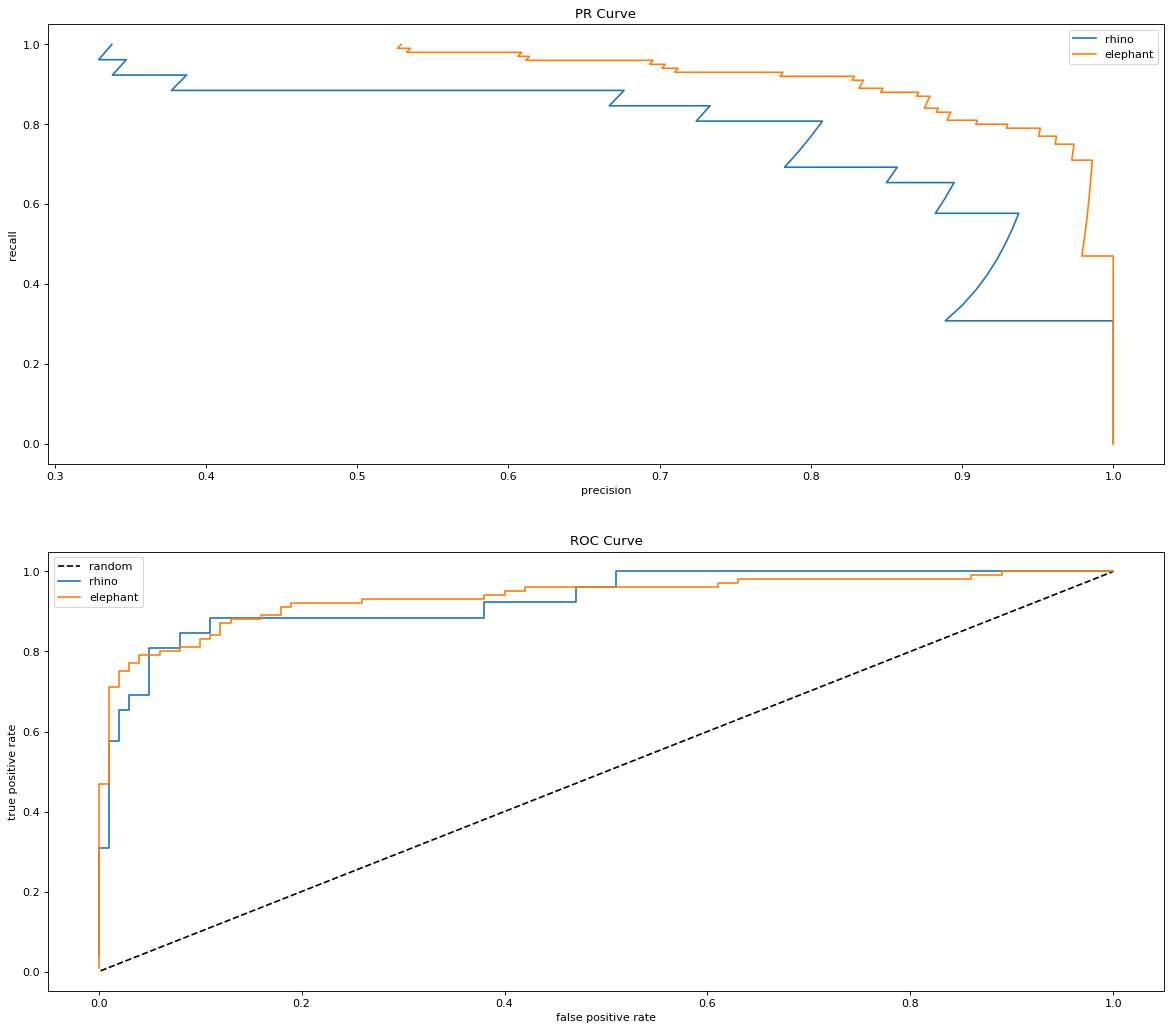

rhino inception based model AUC: 0.929231
elephant inception based model AUC: 0.934400


In [13]:
plot(classifications, ['rhino', 'elephant'])

# Results

rhino inception based model AUC: 0.929231

elephant inception based model AUC: 0.934400

Removing the tapirs imporves both the elephant and the rhino classifiers.  Presumably because they are very different pictures.  It may be the case that the not only are the Tapir pictures at night, but they are infared (TBD).  Either way, this is a promising result.  Especially considering the Rhino classifier performs as well as the Elephant classifier.

## TODO
- Retrain with more images
- Share results with Meredith
- Begin building real tool
